In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
import nltk
import random
nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize
#from fuzzywuzzy import fuzz

train_example_paths = glob.glob('data/train/*.json')
test_example_paths = glob.glob('data/test/*.json')

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
docIdx = train_example_names.copy()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_train_example_by_name(name):
    doc_path = os.path.join('data/train', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

def load_test_example_by_name(name):
    doc_path = os.path.join('data/test', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

## Create dataframe for tokens and targets

In [3]:
def text_cleaning(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text)).strip() # remove unnecessary literals

    text = re.sub(r'\[[0-9]+]', ' specialreference ', text)

    # Remove years
    text = re.sub(r'(19|20)[0-9][0-9]', ' specialyear ', text)

    # remove other digits
    text = re.sub(r'\d+', ' ', text)

    # remove extra spaces
    text = re.sub("\s+"," ", text)

    # Remove websites
    text = ' '.join(['specialwebsite' if 'http' in t or 'www' in t else t for t in text.split(' ') ])

    return text.lower()

In [4]:
import string

##### STEP 1: Make a list of the known labels provided to us

temp_1 = [text_cleaning(x) for x in metadata['dataset_label']]
temp_2 = [text_cleaning(x) for x in metadata['dataset_title']]
temp_3 = [text_cleaning(x) for x in metadata['cleaned_label']]

existing_labels = temp_1 + temp_2 + temp_3
existing_labels = [l.lower() for l in existing_labels]
existing_labels = list(set(existing_labels))

# Sort labels by length in descending order
existing_labels = sorted(existing_labels, key = len, reverse= True)

In [5]:
pos_sentences = []
neg_sentences = []

def process_doc(doc_id):
    doc_json = load_train_example_by_name(doc_id)
    doc_text = ' '.join([sec['text'] for sec in doc_json])

    # Tokenize sentencewise
    sentences = sent_tokenize(doc_text)
    
    for sentence in sentences:
        clean_sentence = text_cleaning(sentence)

        has_label = False
        for clean_label in existing_labels:
            if clean_label in clean_sentence:
                has_label = True

                # Remove label from the text, or model will overfit
                clean_sentence = clean_sentence.replace(clean_label, '')

        if has_label:
            clean_sentence = re.sub("\s+"," ", clean_sentence)
            pos_sentences.append(clean_sentence)
        else:
            if random.uniform(0, 1) < 0.1:
                neg_sentences.append(clean_sentence)

#get_doc(docIdx[0])[0]

## Create Dataset for All Documents

In [6]:
for doc_id in tqdm(docIdx):
    process_doc(doc_id)

print('')
print(f'pos size: {len(pos_sentences)}')
print(f'neg size: {len(neg_sentences)}')

100%|██████████| 14316/14316 [04:25<00:00, 53.89it/s]
pos size: 55482
neg size: 412401



## Save Dataset

In [7]:
import pickle

with open(f'data/sentence_classification_data/pos.pkl', 'wb') as f:
    pickle.dump(pos_sentences, f)

with open(f'data/sentence_classification_data/neg.pkl', 'wb') as f:
    pickle.dump(neg_sentences, f)

print(f'pos size: {len(pos_sentences)}')
print(f'neg size: {len(neg_sentences)}')

pos size: 55482
neg size: 412401


## Load Dataset

In [6]:
import pickle

with open(f'data/sentence_classification_data/pos.pkl', 'rb') as f:
    pos_sentences = pickle.load(f)

with open(f'data/sentence_classification_data/neg.pkl', 'rb') as f:
    neg_sentences = pickle.load(f)

print(f'pos size: {len(pos_sentences)}')
print(f'neg size: {len(neg_sentences)}')

pos size: 55482
neg size: 4123439


## Create Training Data

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

print('Creating TF-IDF vectorizer...')
all_sentences = pos_sentences + neg_sentences
vectorizer = TfidfVectorizer(max_features = 10000, ngram_range = (1, 2), use_idf = False, binary = True).fit(all_sentences)

print('Creating data arrays...')
X = vectorizer.transform(all_sentences)
y = np.zeros(len(all_sentences))
y[:len(pos_sentences)] = 1

print('Saving vectorizer...')
with open(f'data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Creating TF-IDF vectorizer...
Creating data arrays...
Saving vectorizer...


In [37]:
from sklearn.model_selection import train_test_split

print('Splitting data...')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

data = {
    'train_data': (X_train, y_train),
    'val_data': (X_val, y_val)
}

Splitting data...


## Train Model

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Minimize: False
Best hparameters:
{'C': 1.5229112566326333, 'tol': 0.002735625580124892, 'max_iter': 500, 'verbose': 0, 'n_jobs': -1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'auto', 'random_state': 42, 'minimize_metric': False, 'model_class': <class 'sklearn.linear_model._logistic.LogisticRegression'>}
 90%|█████████ | 9/10 [01:30<00:09,  9.34s/trial, best loss: -0.6776606354181507]

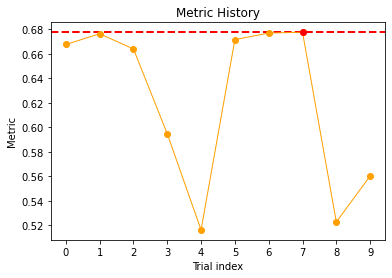

100%|██████████| 10/10 [01:30<00:00,  9.04s/trial, best loss: -0.6776606354181507]
HPARAMETER SEARCH FINISHED.


In [38]:
# Sklearn doesn't work well

"""def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

from mlmodels import sklearn_model
from mlmodels.search.hparameters import lr_params
hparams = lr_params

delete_file('trials_sklearn')
model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, hparams.search_space, hparams.search_fixed, num_iter = 10)
best_hparams = res['best_params']
best_hparams.update(hparams.search_fixed)

model.save()
"""


## Test Doc

In [28]:
with open(f'data/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [42]:
def test_process_doc(doc_id):
    doc_json = load_train_example_by_name(doc_id)
    doc_text = ' '.join([sec['text'] for sec in doc_json])

    # Tokenize sentences
    sentences = sent_tokenize(doc_text)

    sentences_cleaned = [text_cleaning(s).lower() for s in sentences]

    X_test = vectorizer.transform(sentences_cleaned)

    return X_test, sentences_cleaned

In [43]:
test_doc_id = train_example_names[5]
X_test, sentences = test_process_doc(test_doc_id)
doc_preds = model.predict([{'output': X_test}])[0]['output']

pos_pred_idx = np.argwhere(doc_preds == 1)[:, 0]
pos_pred_sentences = [sentences[i] for i in pos_pred_idx]

list(metadata.loc[metadata.Id == test_doc_id, 'cleaned_label'].values)

['adni', 'alzheimer s disease neuroimaging initiative adni ']